In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("/workspaces/MambaLinearCode")
os.chdir("/workspaces/MambaLinearCode")

In [2]:
from configuration import Code, Config
from dataset import get_generator_and_parity
import torch
import os

def code_from_hint(hint,):
    code_files = os.listdir(CODES_PATH)
    code_files = [f for f in code_files if hint in f][0]
    print(code_files)
    code_n = int(code_files.split('_')[1][1:])
    code_k = int(code_files.split('_')[-1][1:].split('.')[0])
    code_type = code_files.split('_')[0]
    code = Code(code_n, code_k, code_type)
    return code

OUTPUT_PATH = ".bench/"
CODES_PATH = "codes/"
example_code = code_from_hint("LDPC_N49_K24")
G,H = get_generator_and_parity(example_code, standard_form=True)
example_code.generator_matrix = torch.from_numpy(G).transpose(0,1).long()
example_code.pc_matrix = torch.from_numpy(H).long()


LDPC_N49_K24.alist


In [3]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset import BER,FER,sign_to_bin,EbN0_to_std,ECC_Dataset, bin_to_sign
from models.AECCT import ECC_Transformer as AECCT
from models.mamba_brute_bidir import ECCM as MBBi
from models.ECCM import ECCM as MaskedMamaba
from models.ECCM_bidir import ECCM as MaskedMambaBidir
from models.ECCM_bidir2 import ECCM as MaskedMambaBidir2
import time
import numpy as np
import logging
from matplotlib import pyplot as plt

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


def aecct_apply_model(model, x, y, magnitude, syndrome, device):
    z_mul = -(y * bin_to_sign(x))
    z_pred = model(magnitude.to(device), syndrome.to(device))
    return model.loss(-z_pred, z_mul.to(device), y.to(device))

def mbbi_apply_model(model, x, y, magnitude, syndrome, device):
    z_mul = -(y * bin_to_sign(x))
    z_pred = model(magnitude.to(device), syndrome.to(device))
    return model.loss(-z_pred, z_mul.to(device), y.to(device))

def masked_mamba_apply_model(model, x, y, magnitude, syndrome, device):
    z_mul = (y * bin_to_sign(x)) # x = 1, y = -1 => z_mul = -1
    z_pred = model(y.to(device), syndrome.to(device))
    return model.loss(z_pred, z_mul.to(device), y.to(device))

def ssm_apply_model(model, x, y, magnitude, syndrome, device):
    z_mul = sign_to_bin(torch.sign(torch.sign(y) * bin_to_sign(x)))
    z_pred = model(-y.to(device), syndrome.to(device)).squeeze(-1)
    loss, x_pred = model.loss(z_pred, z_mul.to(device), y.to(device))
    return loss, x_pred

def masked_mamba_apply_model_magnitude(model, x, y, magnitude, syndrome, device):
    z_mul = (y * bin_to_sign(x)) # x = 1, y = -1 => z_mul = -1
    z_pred = model(magnitude.to(device), syndrome.to(device))
    return model.loss(z_pred, z_mul.to(device), y.to(device))
test_batch_size=2048
bench = [
    (
        "AECCT", AECCT, "logs/Results_AECCT/LDPC__Code_n_49_k_24__17_12_2024_00_32_13/best_model", aecct_apply_model,
            Config(
                code=example_code,
                d_model=128,
                path=OUTPUT_PATH,
                N_dec=6,
                warmup_lr=1.0e-3,
                lr=1e-4,
                epochs=1000,
                eta_min=1e-12,
                test_batch_size=test_batch_size
            )
    ),
    ("MBBi", MBBi, ".semi-workin-brute-biderectional/.output/best_model", mbbi_apply_model,
        Config(
            code=example_code,
            d_model=32,
            d_state=64,
            path=OUTPUT_PATH,
            N_dec=8,
            warmup_lr=1.0e-4,
            lr=1.0e-4,
            epochs=1000,
            test_batch_size=test_batch_size
        )
    ),
    ("MaskedMamba", MaskedMamaba, ".semi-working-mamba-mask/.output/best_model", masked_mamba_apply_model,Config(
        code=example_code,
        d_model=128,
        path=OUTPUT_PATH,
        N_dec=1,
        warmup_lr=1.0e-3,
        lr=1e-4,
        epochs=1000,
        eta_min=1e-12,
        test_batch_size=test_batch_size
    )),
    # ("MaskedMambaLarge", MaskedMamaba, ".semi-working-mamba-mask-large/.output/best_model", masked_mamba_apply_model,Config(
    #     code=example_code,
    #     d_model=128,
    #     path=OUTPUT_PATH,
    #     N_dec=8,
    #     warmup_lr=1.0e-3,
    #     lr=1e-4,
    #     epochs=1000,
    #     eta_min=1e-12,
    #     test_batch_size=test_batch_size
    # )),
    ("MaskedMambaBidir", MaskedMambaBidir, ".semi-working-mamba-mask-large-bidir/.output-2/best_model", masked_mamba_apply_model,Config(
        code=example_code,
        d_model=128,
        path=OUTPUT_PATH,
        N_dec=2,
        warmup_lr=1.0e-3,
        lr=1e-4,
        epochs=1000,
        eta_min=1e-12,
        test_batch_size=test_batch_size
    )),
    ("MaskedMambaBidir-4", MaskedMambaBidir2, ".semi-working-mamba-mask-large-bidir/.output-4/best_model", masked_mamba_apply_model_magnitude,Config(
        code=example_code,
        d_model=128,
        path=OUTPUT_PATH,
        N_dec=4,
        warmup_lr=1.0e-3,
        lr=1e-4,
        epochs=1000,
        eta_min=1e-12,
        test_batch_size=test_batch_size
    )),("MaskedMambaBidir-8", MaskedMambaBidir2, ".semi-working-mamba-mask-large-bidir/.output-8-070125/best_model", masked_mamba_apply_model_magnitude,Config(
        code=example_code,
        d_model=128,
        path=OUTPUT_PATH,
        N_dec=8,
        warmup_lr=1.0e-3,
        lr=1e-4,
        epochs=1000,
        eta_min=1e-12,
        test_batch_size=test_batch_size
    )),("MaskedMambaBidir-8-GClip", MaskedMambaBidir2, ".semi-working-mamba-mask-large-bidir/.output-8-clip-070125/best_model", masked_mamba_apply_model_magnitude,Config(
        code=example_code,
        d_model=128,
        path=OUTPUT_PATH,
        N_dec=8,
        warmup_lr=1.0e-3,
        lr=1e-4,
        epochs=1000,
        eta_min=1e-12,
        test_batch_size=test_batch_size
    )),

]
results = {}
for name, model, model_path, apply_model, config in bench:
    print(name)
    model = model(config).to('cuda')
    model.load_state_dict(torch.load(model_path))
    def test(model, device, test_loader_list, EbNo_range_test, min_FER=100):
        model.eval()
        t = time.time()
        result = {}
        with torch.no_grad():
            for ii, test_loader in enumerate(test_loader_list):
                test_loss = test_ber = test_fer = cum_count = test_in_err = 0.
                for m, x, z, y, magnitude, syndrome in tqdm(test_loader, position=0, leave=True, desc="Testing"):
                    loss, x_pred = apply_model(model, x,y, magnitude,syndrome,device)
                    
                    test_loss += loss.item() * x.shape[0]
                    test_in_err += BER(sign_to_bin(torch.sign(y)),x) * x.shape[0]
                    test_ber += BER(x_pred, x.to(device)) * x.shape[0]
                    test_fer += FER(x_pred, x.to(device)) * x.shape[0]
                    cum_count += x.shape[0]
                test_loss /= cum_count
                test_ber /= cum_count
                test_fer /= cum_count
                test_in_err /= cum_count
                ln_ber = -np.log(test_ber)
                logging.info(f'Test EbN0={EbNo_range_test[ii]}, BER={test_ber:.2e} in_err={test_in_err:.2e}, -ln(BER)={ln_ber:.2e} loss={test_loss:.2e}' )
                result[EbNo_range_test[ii]]  = test_ber
        return result

    def _test(config, model):
        EbNo_range_test = range(0,11)
        code = config.code
        std_test = [EbN0_to_std(ii, code.k / code.n) for ii in EbNo_range_test]
        test_dataloader_list = [DataLoader(ECC_Dataset(code, [std_test[ii]], len=int(config.test_batch_size), zero_cw=False),
                                            batch_size=config.test_batch_size, shuffle=False, num_workers=1) for ii in range(len(std_test))]
        return test(model, 'cuda', test_dataloader_list, EbNo_range_test)
    result = _test(config, model)
    results[name] = result
    print(sum(p.numel() for p in model.parameters()))

    

AECCT


/tmp/ipykernel_21880/57069274.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 1/1 [00:01<00:00,

1203359
MBBi


Testing: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


279521
MaskedMamba


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


115055
MaskedMambaBidir


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


226288
MaskedMambaBidir-4


Testing: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


448754
MaskedMambaBidir-8


Testing: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


893686
MaskedMambaBidir-8-GClip


Testing: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

893686


/tmp/ipykernel_21880/1326157995.py:4: RuntimeWarning: divide by zero encountered in log
  ax2.plot(list(result.keys()), -np.log(list(result.values())), label=name)


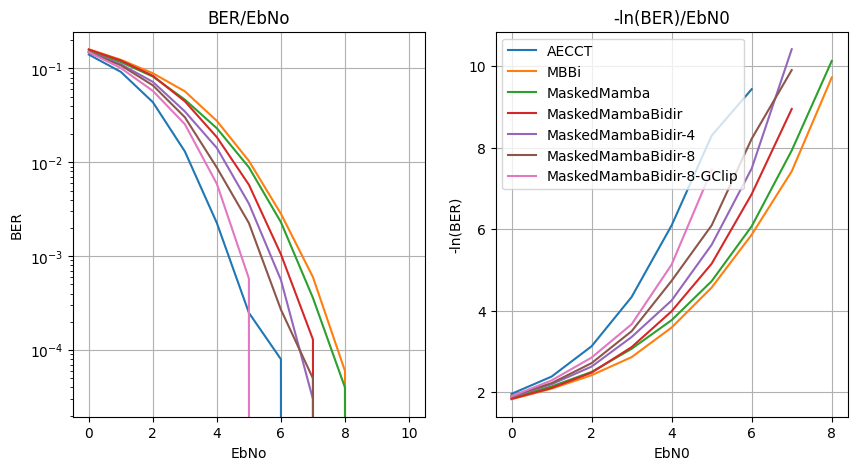

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
for name, result in results.items():
    ax1.plot(list(result.keys()), list(result.values()), label=name)
    ax2.plot(list(result.keys()), -np.log(list(result.values())), label=name)
ax1.set_title("BER/EbNo")
ax1.set_xlabel("EbNo")
ax1.set_ylabel("BER")
ax1.set_yscale("log", base=10)
ax1.grid()
ax2.set_title('-ln(BER)/EbN0')
ax2.set_xlabel("EbN0")
ax2.set_ylabel("-ln(BER)")
ax2.grid()
plt.legend()